22050


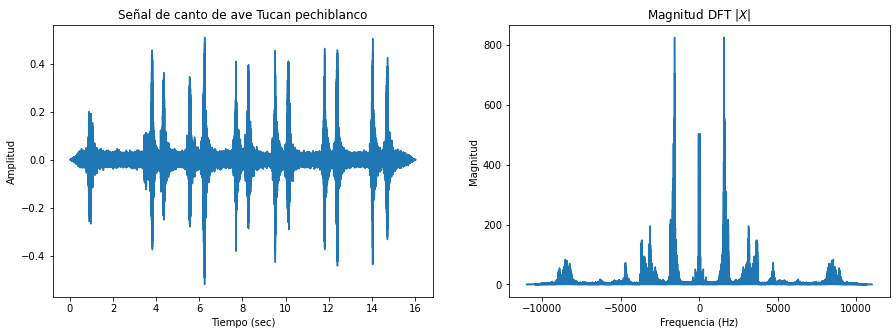

In [40]:
import pandas as pd
import numpy as np
import librosa
from librosa import display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
import scipy
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.signal as signal


#Cargamos el audio con librosa.load()

AudioName = "CantoTucan.WAV"
y, fs = librosa.load('CantoTucan.WAV')
print(fs)


#Graficamos la señal de varias maneras, para poder hacer una pre visualización

t = np.arange(y.shape[0]) / fs
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(t, y) 
plt.title('Señal de canto de ave Tucan pechiblanco')
plt.xlabel('Tiempo (sec)')
plt.ylabel('Amplitud')

x = np.fft.fft(y) 
freq = np.fft.fftfreq(y.size, d=1/fs)
plt.subplot(1, 2, 2)
plt.plot(freq, np.abs(x))
plt.title('Magnitud DFT $|X|$')
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Magnitud') 
plt.show()

#Escuchamos el audio 
ipd.Audio(y, rate=fs)


# **Filtro FIR por ventanas**



float32
22050


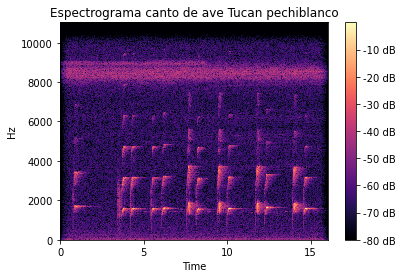

In [66]:

#Graficamos el espectrográma de la señal original 

D = librosa.stft(y) 
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Espectrograma canto de ave Tucan pechiblanco')
fig.colorbar(img, ax=ax, format="%+2.f dB")
print(S_db.dtype)
print(fs)

#Guardamos el espectrograma como imagen 
plt.savefig('espectrogramaAudioSinProcesar.png')
plt.show()


In [67]:
def metodo_ventanas (N,fs,fc1,fc2):
    
    M = N + 1 
    
    M_des = (M-1)/2 # indeterminación

    n = np.linspace(0,M-1,M) 
    
    # Frecuencia de corte 1  normalizada
    fc1 = (2 * np.pi * fc1)/fs  
    
    # Frecuencia de corte 2  normalizada
    fc2 = (2 * np.pi * fc2)/fs 
    
    # Ventana Hanning 
    ventanaHanning = (1/2)*(1-np.cos(2*np.pi*n/(M-1))) 
    
    # Ventana Hamming 
    ventanaHamming = 0.42-0.5*(np.cos((2*np.pi*n)/M))+0.08*(np.cos((4*np.pi*n)/M))
    
    #Ecuación filtro pasa  banda
    hn2 =  (np.sin(fc2*(n- M_des)) / (np.pi*(n - M_des))) - (np.sin(fc1*(n- M_des)) / (np.pi*(n - M_des)))   
    hn2[round(M_des)] = (fc2-fc1)/(np.pi)
    
    hn2 = hn2 * ventanaHamming # Enventanamiento

    Hnormalizada = hn2/max(hn2) # Filtro normalizado  
    
    return [hn2,Hnormalizada,ventanaHamming, n]

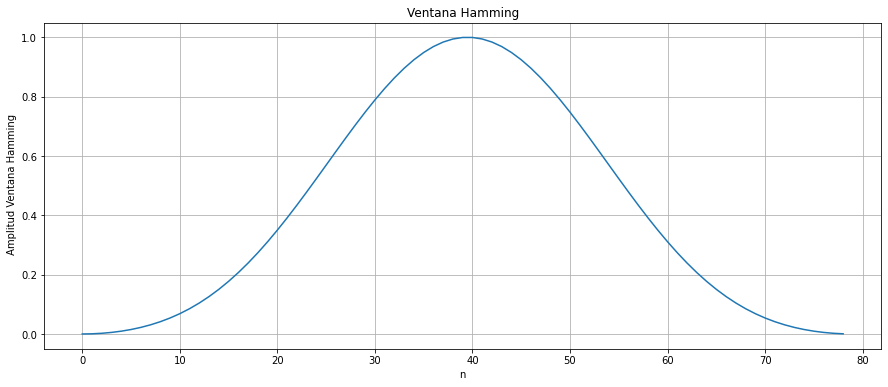

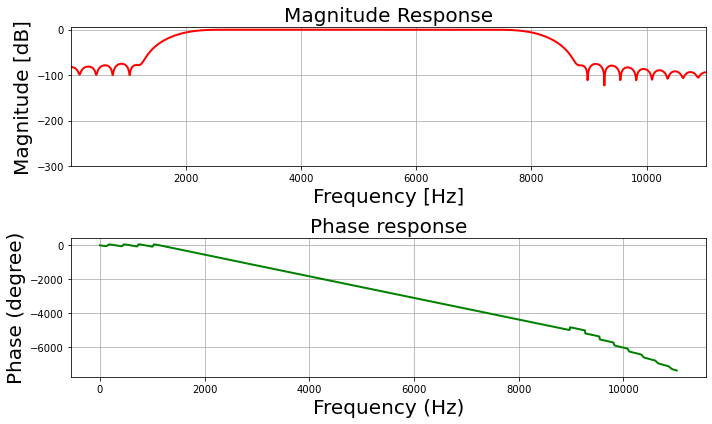

In [68]:
# Graficaremos las salidas de nuestra función "metodo_ventanas()"

#Número de muestras con que se define nuestro audio 

N = 78  #y.shape[0]  #LOS GRAFICOS DE MAGNITUD Y FASE BONITOS...


#Frecuencia de corte 1  elegida ... Componentes frecuenciales menores a 2000 Hz
fc1 = 2000

# Frecuencia de corte 2  elegida ... Ruido provocado por insectos 
fc2 = 8000 

                                                     # M,fs,fc1,fc2
[hn2,filtroNormalizado, ventana,n] = metodo_ventanas (N,fs,fc1,fc2)


# Visualización de la ventana implementada ( Hamming ) 

plt.figure(figsize = (15,6))
plt.plot(n,ventana)
plt.grid()
plt.xlabel('n')
plt.ylabel(' Amplitud Ventana Hamming')
plt.title('Ventana Hamming')


#Calculamos la respuesta de frecuencia del filtro digital

w, h = signal.freqz(hn2, 1, worN=2000)

# Calculo de la magnitud de hz en dB
Mag = 20*np.log10(abs(h)) 
 
# Calculo del angulo de fase en grados desde hz 
Phase = np.unwrap(np.arctan2(np.imag(h), np.real(h)))*(180/np.pi)
     
# Calcular la frecuencia en Hz a partir de wz
Freq = w*fs/(2*np.pi)
     
# Graficando la magnitud del filtro y las respuestas de fase usando subplot.                  
fig = plt.figure(figsize=(10, 6))
 
# Graficando la respuesta de magnitud  
sub1 = plt.subplot(2, 1, 1)
sub1.plot(Freq, Mag, 'r', linewidth=2)
sub1.axis([1, fs/2, -300, 5])
sub1.set_title('Magnitude Response', fontsize=20)
sub1.set_xlabel('Frequency [Hz]', fontsize=20)
sub1.set_ylabel('Magnitude [dB]', fontsize=20)
sub1.grid()
 
# Graficando el angulo de fase
sub2 = plt.subplot(2, 1, 2)
sub2.plot(Freq, Phase, 'g', linewidth=2)
sub2.set_ylabel('Phase (degree)', fontsize=20)
sub2.set_xlabel(r'Frequency (Hz)', fontsize=20)
sub2.set_title(r'Phase response', fontsize=20)
sub2.grid()
 
plt.subplots_adjust(hspace=0.5)
fig.tight_layout()
plt.show()


<StemContainer object of 3 artists>

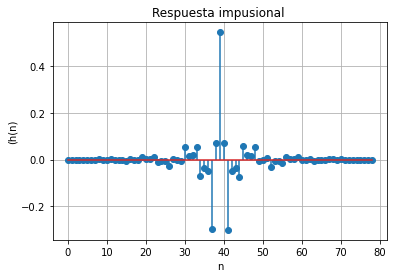

In [69]:
#Respuesta al impulso


t = np.linspace(0,N-1,N)
plt.show()
fig = plt.figure()
ax = fig.add_subplot()
ax.grid(True)
ax.set_title("Respuesta impusional ")
ax.set_xlabel('n')
ax.set_ylabel('(h(n)')
plt.stem(hn2)


#----------------------------------------------------


**Espectograma filtro FIR por ventanas**

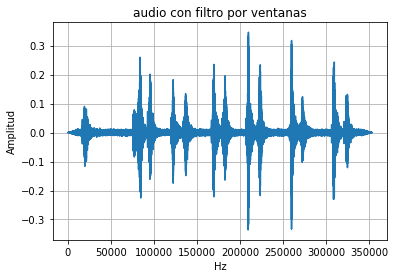

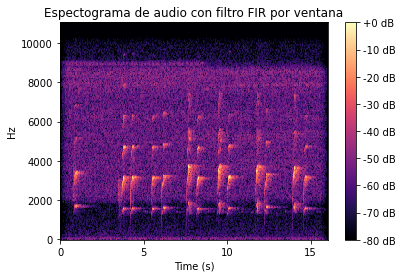

In [39]:
# Convolucionamos el filtro con la data de nuestro audio

import soundfile as sf

conv = np.convolve(y,hn2, mode = "same")

fig = plt.figure()
plt.plot(conv)
plt.title('audio con filtro por ventanas')
plt.xlabel('Hz')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

aveswin1_fft = librosa.stft(conv, n_fft=512) 
AmpDB = librosa.amplitude_to_db(np.abs(aveswin1_fft), ref=np.max)

fig, ax = plt.subplots()
#spec = librosa.display.specshow(AmpDB, sr=fs, n_fft=512,hop_length=128, x_axis='s', y_axis='linear', ax=ax)
spec = librosa.display.specshow(AmpDB, sr=fs, n_fft=512,hop_length=128, x_axis='s', y_axis='linear', ax=ax)
ax.set(title='Espectograma de audio con filtro FIR por ventana')
plt.colorbar(spec, ax=ax, format="%+2.f dB")

#Escuchamos el audio 
ipd.Audio(conv, rate=fs)
        


# Filtro FIR por Chebyshev

In [62]:
from scipy.signal import remez
y, fs = librosa.load('CantoTucan.WAV')

#Filtro pasa banda mediante remez

#Definimos las condiciones para el diseño de nuestro filtro 

anchoTransicion = 512
tamañoFiltro = 157 #128 #7

B_Paso = 2000 #Borde banda paso
B_Supresora = 8000 ##Borde banda supresora 


# Formula de Kaiser ---------------------------------------------------------------------

Delta_p = 0.03 #rizo basabanda
Delta_s=0.007 #rizo SupresoraE

Delta_Normalizada = (B_Supresora-B_Paso)/fs

M = ((-20*np.log10(np.sqrt(Delta_p*Delta_s))-13)/(14.6*Delta_Normalizada))+1 # Fórmula de Kaiser
print(M)

#------------------------------------------------------------------------------------------

anchoTransmision = 0.5 * anchoTransicion
edges = [0, B_Paso - anchoTransmision, B_Paso + anchoTransmision, B_Supresora - anchoTransmision, B_Supresora + anchoTransmision, 0.5*fs]
taps = remez(tamañoFiltro, edges, [0, 1, 0], Hz=fs)

indicesRemez = taps

#Calculamos la respuesta de frecuencia del filtro digital
wchevishev, hchevishev = signal.freqz(indicesRemez, 1, worN=2000)



6.985167186200581


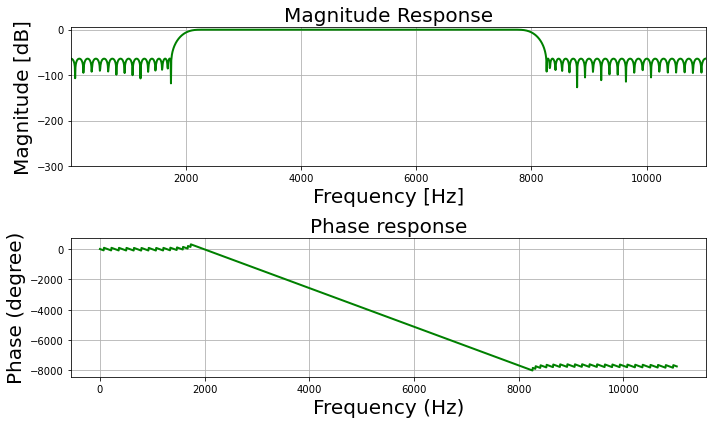

In [64]:

# Calculo de la magnitud de hz en dB
Mag = 20*np.log10(abs(hchevishev)) 
 
# Calculo del angulo de fase en grados desde hz 
Phase = np.unwrap(np.arctan2(np.imag(hchevishev), np.real(hchevishev)))*(180/np.pi)
     
# Calcular la frecuencia en Hz a partir de wz
Freq = wchevishev*fs/(2*np.pi)
     
# Graficando la magnitud del filtro y las respuestas de fase usando subplot.                  
fig = plt.figure(figsize=(10, 6))
 
# Graficando la respuesta de magnitud  
sub1 = plt.subplot(2, 1, 1)
sub1.plot(Freq, Mag, 'g', linewidth=2)
sub1.axis([1, fs/2, -300, 5])
sub1.set_title('Magnitude Response', fontsize=20)
sub1.set_xlabel('Frequency [Hz]', fontsize=20)
sub1.set_ylabel('Magnitude [dB]', fontsize=20)
sub1.grid()
 
# Graficando el angulo de fase
sub2 = plt.subplot(2, 1, 2)
sub2.plot(Freq, Phase, 'g', linewidth=2)
sub2.set_ylabel('Phase (degree)', fontsize=20)
sub2.set_xlabel(r'Frequency (Hz)', fontsize=20)
sub2.set_title(r'Phase response', fontsize=20)
sub2.grid()
 
plt.subplots_adjust(hspace=0.5)
fig.tight_layout()
plt.show()


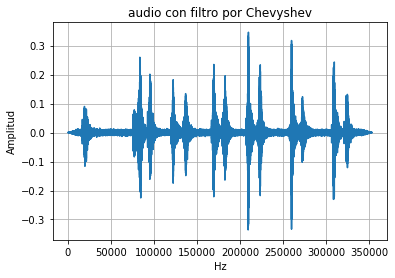

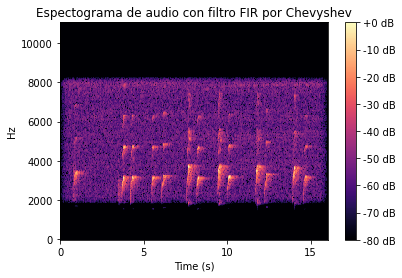

In [65]:

conv2 = np.convolve(y,indicesRemez, mode = "same")

fig = plt.figure()
plt.plot(conv)
plt.title('audio con filtro por Chevyshev')
plt.xlabel('Hz')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

aveswin1_fft = librosa.stft(conv2, n_fft=512) 
AmpDB = librosa.amplitude_to_db(np.abs(aveswin1_fft), ref=np.max)

fig, ax = plt.subplots()
#spec = librosa.display.specshow(AmpDB, sr=fs, n_fft=512,hop_length=128, x_axis='s', y_axis='linear', ax=ax)
spec = librosa.display.specshow(AmpDB, sr=fs, n_fft=512,hop_length=128, x_axis='s', y_axis='linear', ax=ax)
ax.set(title='Espectograma de audio con filtro FIR por Chevyshev')
plt.colorbar(spec, ax=ax, format="%+2.f dB")

#Escuchamos el audio 
ipd.Audio(conv, rate=fs)

